In [403]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from pandas import get_dummies
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint

In [100]:
import pandas as pd

In [10]:
%matplotlib inline

In [377]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:10000], data[10000:15000]
    # reshaping the data for restructuring
	train = array(train).reshape(train.shape[0],train.shape[1])
	test = array(test).reshape(test.shape[0],test.shape[1])
	# restructure into windows of weekly data
	train = array(split(train, len(train)/20))
	test = array(split(test, len(test)/20))
	print('The shape of train is: ',train.shape, 'The data structure is: [samples,timesteps, features]') 
	print('The shape of test is: ',test.shape, 'The data structure is: [samples,timesteps, features]')
	return train, test

In [58]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [59]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	print(actual.shape)
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [60]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [61]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=20):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

##### ED-LSTM Model

In [407]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="ed_lstm.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

##### LSTM Model

In [408]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="lstm.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

##### CNN-LSTM Model

In [400]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [63]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [114]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
    
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) # index number of imbalance in test set is imp
	return score, scores, predictions

In [2]:
# load the new data file
dataset = read_csv('trainData_set1.csv')

In [313]:
dataset['D1'] = dataset.BIDASKIMBALANCE - dataset.BIDASKIMBALANCE.shift(1)

In [314]:
dataset['D2'] = dataset.D1 - dataset.D1.shift(1)

In [325]:
dataset = dataset.dropna()

In [326]:
# extracting a single feature
X0 = pd.DataFrame(dataset.BIDASKIMBALANCE)

In [327]:
X1 = dataset[['TICKDIR','LASTTICKDIR','LASTTICKDIR1','LASTTICKDIR2','LASTTICKDIR3']]

In [328]:
X1a = get_dummies(X1)

In [329]:
X1a.shape

(52394, 25)

In [330]:
X1a.head()

TICKDIR_DOWN  TICKDIR_DOWNCYCLE  TICKDIR_FLAT  TICKDIR_UP  TICKDIR_UPCYCLE  \
2             0                  0             1           0                0   
3             0                  0             1           0                0   
4             0                  0             1           0                0   
5             0                  0             1           0                0   
6             0                  0             1           0                0   

   LASTTICKDIR_DOWN  LASTTICKDIR_DOWNCYCLE  LASTTICKDIR_FLAT  LASTTICKDIR_UP  \
2                 0                      0                 1               0   
3                 0                      0                 1               0   
4                 0                      0                 1               0   
5                 0                      0                 1               0   
6                 0                      0                 1               0   

   LASTTICKDIR_UPCYCLE  ...  LASTTICKDIR2_DOWN  LASTTICKDIR2_DOWNCYCLE  \
2                    0  ...                  0                       0   
3                    0  ...                  0                       0   
4                    0  ...                  0                       0   
5                    0  ...                  0                       0   
6                    0  ...                  0                       0   

   LASTTICKDIR2_FLAT  LASTTICKDIR2_UP  LASTTICKDIR2_UPCYCLE  \
2                  1                0                     0   
3                  1                0                     0   
4                  1                0                     0   
5                  1                0                     0   
6                  1                0                     0   

   LASTTICKDIR3_DOWN  LASTTICKDIR3_DOWNCYCLE  LASTTICKDIR3_FLAT  \
2                  0                       0                  1   
3                  0                       0                  1   
4                  0                       0                  1   
5                  0                       0                  1   
6                  0                       0                  1   

   LASTTICKDIR3_UP  LASTTICKDIR3_UPCYCLE  
2                0                     0  
3                0                     0  
4                0                     0  
5                0                     0  
6                0                     0  

[5 rows x 25 columns]

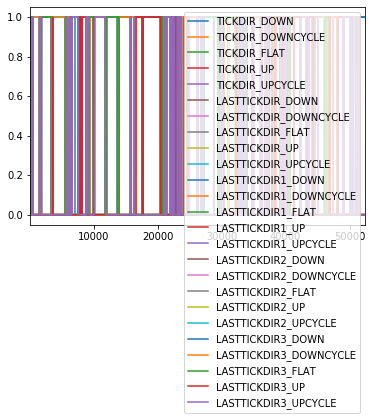

In [331]:
X1a.plot();

##### Adding Feature :
- ['BIDVOLUME','ASKVOLUME','TOTALBIDVOLUME','TOTALASKVOLUME','TOTALVOLUME','BIDVOLUME1']
- ['ASKVOLUME1','BIDVOLUME2','ASKVOLUME2','BIDVOLUME3','ASKVOLUME3']

In [332]:
X2 = dataset[['BIDVOLUME','ASKVOLUME','TOTALBIDVOLUME','TOTALASKVOLUME','TOTALVOLUME','BIDVOLUME1',
             'ASKVOLUME1','BIDVOLUME2','ASKVOLUME2','BIDVOLUME3','ASKVOLUME3']]

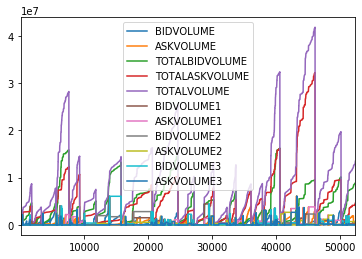

In [333]:
X2.plot();

In [141]:
from sklearn import preprocessing

In [334]:
X2a = array(X2)

In [170]:
#X2a = X2.values #returns a numpy array
normalize_scaler = preprocessing.Normalizer(norm='l2')
x_scaled = normalize_scaler.fit_transform(X2a)
df_Normal = pd.DataFrame(data=x_scaled, columns=['BIDVOLUME_N'])

In [335]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X2a)
df_Normal = pd.DataFrame(data=x_scaled, columns=['BIDVOLUME_N','ASKVOLUME_N','TOTALBIDVOLUME_N','TOTALASKVOLUME_N',
                                                  'TOTALVOLUME_N','BIDVOLUME1_N',
             'ASKVOLUME1_N','BIDVOLUME2_N','ASKVOLUME2_N','BIDVOLUME3_N','ASKVOLUME3_N'])

In [210]:
std_scaler = preprocessing.StandardScaler()
x_scaled = std_scaler.fit_transform(X2a)
df_Normal = pd.DataFrame(data=x_scaled, columns=['BIDVOLUME_N'])

In [336]:
df_Normal.head()

BIDVOLUME_N  ASKVOLUME_N  TOTALBIDVOLUME_N  TOTALASKVOLUME_N  \
0          0.0     0.000000               0.0          0.000000   
1          0.0     0.000016               0.0          0.000003   
2          0.0     0.000016               0.0          0.000003   
3          0.0     0.000016               0.0          0.000003   
4          0.0     0.000180               0.0          0.000034   

   TOTALVOLUME_N  BIDVOLUME1_N  ASKVOLUME1_N  BIDVOLUME2_N  ASKVOLUME2_N  \
0       0.000000           0.0           0.0           0.0           0.0   
1       0.000002           0.0           0.0           0.0           0.0   
2       0.000002           0.0           0.0           0.0           0.0   
3       0.000002           0.0           0.0           0.0           0.0   
4       0.000026           0.0           0.0           0.0           0.0   

   BIDVOLUME3_N  ASKVOLUME3_N  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0

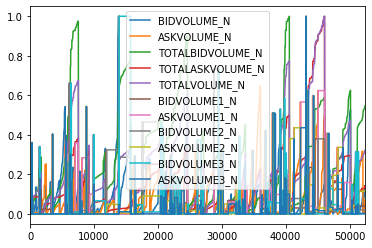

In [337]:
df_Normal.plot();

In [338]:
X1b = X1a.join(df_Normal)

##### Adding Feature 
- ['BIDTRADE','ASKTRADE','BIDTRADE1','ASKTRADE1','BIDTRADE2','ASKTRADE2','BIDTRADE3','ASKTRADE3']

In [339]:
X3 = dataset[['BIDTRADE','ASKTRADE','BIDTRADE1','ASKTRADE1','BIDTRADE2','ASKTRADE2','BIDTRADE3','ASKTRADE3']]

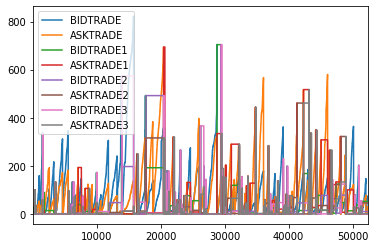

In [340]:
X3.plot();

In [341]:
X3a = array(X3)

In [199]:
std_scaler = preprocessing.StandardScaler()
x_scaled3 = std_scaler.fit_transform(X3a)
df_Normal3 = pd.DataFrame(data=x_scaled3, columns=['ASKVOLUME_N'])

In [342]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled3 = min_max_scaler.fit_transform(X3a)
df_Normal3 = pd.DataFrame(data=x_scaled3, columns=['BIDTRADE_N','ASKTRADE_N','BIDTRADE1_N','ASKTRADE1_N',
                                                   'BIDTRADE2_N','ASKTRADE2_N','BIDTRADE3_N','ASKTRADE3_N'])

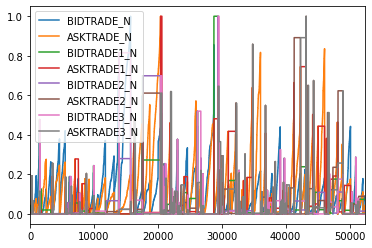

In [343]:
df_Normal3.plot();

In [344]:
X1c = X1b.join(df_Normal3)

##### Adding Feature
- ['BIDSIZE','ASKSIZE']
- ['D1','D2']

In [345]:
X4 = dataset[['BIDSIZE','ASKSIZE','D1','D2']]

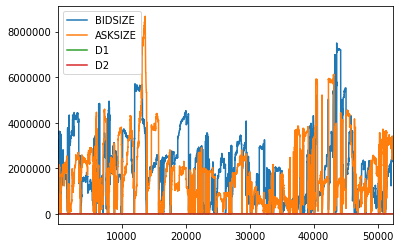

In [346]:
X4.plot();

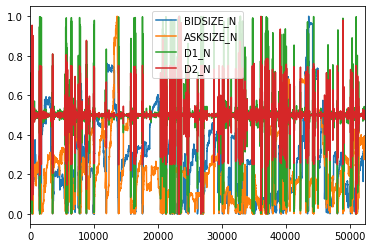

In [347]:
X4a = array(X4)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled4 = min_max_scaler.fit_transform(X4a)
df_Normal4 = pd.DataFrame(data=x_scaled4, columns=['BIDSIZE_N','ASKSIZE_N','D1_N','D2_N'])
df_Normal4.plot();

In [348]:
X1d = X1c.join(df_Normal4)

##### Adding Feature
- ['LASTTICKDURATION','LASTTICKDURATION1','LASTTICKDURATION2','LASTTICKDURATION3','MARKETTIME']

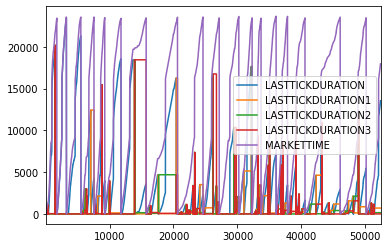

In [349]:
X5 = dataset[['LASTTICKDURATION','LASTTICKDURATION1','LASTTICKDURATION2','LASTTICKDURATION3','MARKETTIME']]
X5.plot();

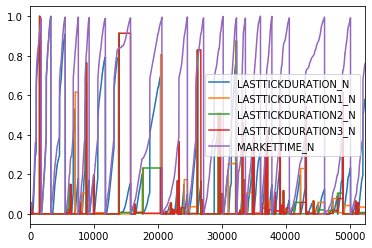

In [410]:
X5a = array(X5)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled5 = min_max_scaler.fit_transform(X5a)
df_Normal5 = pd.DataFrame(data=x_scaled5, columns=['LASTTICKDURATION_N','LASTTICKDURATION1_N',
                                                   'LASTTICKDURATION2_N','LASTTICKDURATION3_N','MARKETTIME_N'])
df_Normal5.plot();

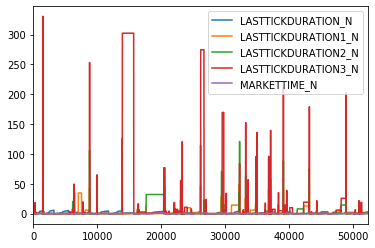

In [411]:
X5a = array(X5)
robust_scaler = preprocessing.RobustScaler()
x_scaled5 = robust_scaler.fit_transform(X5a)
df_Normal5 = pd.DataFrame(data=x_scaled5, columns=['LASTTICKDURATION_N','LASTTICKDURATION1_N',
                                                   'LASTTICKDURATION2_N','LASTTICKDURATION3_N','MARKETTIME_N'])
df_Normal5.plot();

In [351]:
X1e = X1d.join(df_Normal5)

##### Adding Feature - ASK, ASK1, ASK2, ASK3, BID, BID1, BID2, BID3

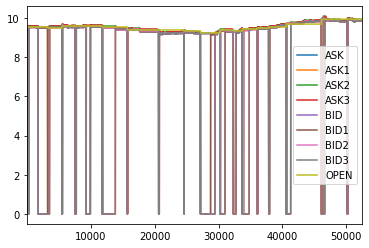

In [352]:
X6 = dataset[['ASK','ASK1','ASK2','ASK3', 'BID','BID1', 'BID2','BID3', 'OPEN']]
X6.plot();

In [353]:
X6.shape

(52394, 9)

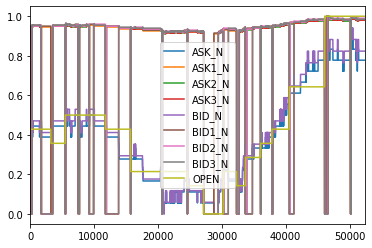

In [354]:
X6a = array(X6)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled6 = min_max_scaler.fit_transform(X6a)
df_Normal6 = pd.DataFrame(data=x_scaled6, columns=['ASK_N','ASK1_N','ASK2_N','ASK3_N', 'BID_N','BID1_N', 'BID2_N',
                                                   'BID3_N','OPEN'])
df_Normal6.plot();

In [355]:
X1f = X1e.join(df_Normal6)

##### Consolidate Dataset

In [356]:
X_Full = X0.join(X1f)

In [357]:
X_Full.head()

BIDASKIMBALANCE  TICKDIR_DOWN  TICKDIR_DOWNCYCLE  TICKDIR_FLAT  TICKDIR_UP  \
2         0.832058             0                  0             1           0   
3         0.829723             0                  0             1           0   
4         0.829861             0                  0             1           0   
5         0.816653             0                  0             1           0   
6         0.816598             0                  0             1           0   

   TICKDIR_UPCYCLE  LASTTICKDIR_DOWN  LASTTICKDIR_DOWNCYCLE  LASTTICKDIR_FLAT  \
2                0                 0                      0                 1   
3                0                 0                      0                 1   
4                0                 0                      0                 1   
5                0                 0                      0                 1   
6                0                 0                      0                 1   

   LASTTICKDIR_UP  ...  MARKETTIME_N     ASK_N  ASK1_N  ASK2_N  ASK3_N  \
2               0  ...      0.000169  0.444444     0.0     0.0     0.0   
3               0  ...      0.000423  0.444444     0.0     0.0     0.0   
4               0  ...      0.000677  0.444444     0.0     0.0     0.0   
5               0  ...      0.000677  0.444444     0.0     0.0     0.0   
6               0  ...      0.001184  0.444444     0.0     0.0     0.0   

      BID_N  BID1_N  BID2_N  BID3_N      OPEN  
2  0.470588     0.0     0.0     0.0  0.428571  
3  0.470588     0.0     0.0     0.0  0.428571  
4  0.470588     0.0     0.0     0.0  0.428571  
5  0.470588     0.0     0.0     0.0  0.428571  
6  0.470588     0.0     0.0     0.0  0.428571  

[5 rows x 63 columns]

In [176]:
train, test = X_Full[0:200], X_Full[-220:-20]

In [177]:
train.shape

(200, 7)

In [178]:
train = array(train).reshape(train.shape[0],train.shape[1]) # 1 being the number of features [samples,timesteps, features]

In [179]:
train = array(split(train, len(train)/20))

In [180]:
train.shape # 6 being the number of features [samples,timesteps, features]

(10, 20, 7)

In [181]:
train_x, train_y = to_supervised(train, n_input)

In [182]:
train_x.shape

(120, 60, 7)

In [183]:
train_y.shape

(120, 20)

In [112]:
train_x[0]

array([[ 0.98101266,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.98053054,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.83205763,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.82972345,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.82986059,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.81665303,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.81659844,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.81795158,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.81842496,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.80010296,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.79983822,  0.        ,  0.        ,  1.

In [113]:
train_y[0]

array([-0.70528115, -0.70529165, -0.69893923,  0.15392983,  0.47480014,
        0.25904422,  0.25738754,  0.21111875,  0.18567433,  0.18226808,
        0.18189632,  0.18241049,  0.17487367,  0.15128662,  0.15137453,
        0.13342218,  0.12788742,  0.12807305,  0.12802503,  0.12900757])

##### Split Data

In [388]:
# split into train and test
train, test = split_dataset(X_Full.values)

The shape of train is:  (500, 20, 63) The data structure is: [samples,timesteps, features]
The shape of test is:  (250, 20, 63) The data structure is: [samples,timesteps, features]


##### Evaluate Model and Get Scores

In [381]:
# evaluate model and get scores
n_input = 60
score_ED_LSTM, scores_ED_LSTM, predictions = evaluate_model(train, test, n_input)

(250, 20)


In [409]:
# evaluate model and get scores
n_input = 60
score_lstm, scores_LSTM, predictions = evaluate_model(train, test, n_input)


Epoch 00001: saving model to lstm.hdf5

Epoch 00002: saving model to lstm.hdf5

Epoch 00003: saving model to lstm.hdf5
(250, 20)


In [401]:
# evaluate model and get scores
n_input = 60
score_CNN_LSTM, scores_CNN_LSTM, predictions = evaluate_model(train, test, n_input)

(250, 20)


LSTM: [0.298] 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3
ED_LSTM: [0.441] 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5
CNN_LSTM: [0.448] 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4


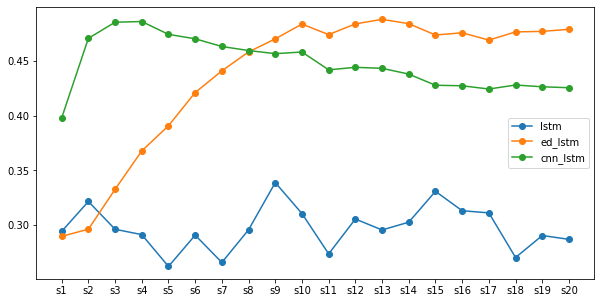

In [402]:
# summarize scores
summarize_scores('LSTM', score_lstm, scores_LSTM)
summarize_scores('ED_LSTM', score_ED_LSTM, scores_ED_LSTM)
summarize_scores('CNN_LSTM', score_CNN_LSTM, scores_CNN_LSTM)
# plot scores
days = ['s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10','s11', 's12', 's13', 's14', 's15', 's16', 's17','s18','s19','s20']
pyplot.figure(figsize=(10,5))
pyplot.plot(days, scores_LSTM, marker='o', label='lstm')
pyplot.plot(days, scores_ED_LSTM, marker='o', label='ed_lstm')
pyplot.plot(days, scores_CNN_LSTM, marker='o', label='cnn_lstm')
pyplot.legend()
pyplot.show()

In [412]:
predictions.shape

(250, 20)

In [420]:
predictions[30]

array([0.34153706, 0.35504505, 0.36419502, 0.2812964 , 0.33397907,
       0.33544672, 0.30758214, 0.27496308, 0.28565857, 0.23600882,
       0.30500025, 0.25114173, 0.25977966, 0.23117557, 0.22416021,
       0.20589775, 0.2467891 , 0.16854283, 0.17304578, 0.19129874],
      dtype=float32)

In [414]:
test[:, :, 0]

array([[-0.99022261, -0.98990036, -0.99034906, ..., -0.91657754,
        -0.92514288, -0.92259498],
       [-0.92704761, -0.92929598, -0.92982907, ..., -0.02976659,
        -0.0290642 , -0.02817442],
       [-0.02566184, -0.02501604, -0.99983314, ...,  0.91836221,
         0.91603117,  0.76788062],
       ...,
       [-0.27436363, -0.27430202, -0.27437596, ..., -0.27236431,
        -0.2739747 , -0.27390053],
       [-0.27398706, -0.27407382, -0.27463805, ..., -0.27767942,
        -0.27550812, -0.27548645],
       [-0.27618044, -0.27608197, -0.27619274, ..., -0.27878356,
        -0.2792285 , -0.27901134]])

In [464]:
predictionDF = pd.DataFrame(data=predictions[230:], columns=['s1', 's2', 's3', 's4', 's5', 's6', 's7',
                                                       's8','s9','s10','s11', 's12', 's13', 's14', 's15',
                                                       's16', 's17','s18','s19','s20'])

In [465]:
predictionDF.describe()

s1         s2         s3         s4         s5         s6  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.179647   0.468145   0.988939   0.528330   0.643949   1.264155   
std     0.055789   0.193609   0.460767   0.194083   0.310214   0.455539   
min    -0.041518   0.400488   0.831131   0.457977   0.541542   1.112219   
25%     0.190493   0.406906   0.838908   0.463909   0.548127   1.117201   
50%     0.195800   0.411311   0.846888   0.467276   0.552397   1.119258   
75%     0.201330   0.413857   0.855356   0.472025   0.555987   1.125056   
max     0.210208   1.227631   2.758839   1.269155   1.874016   2.997051   

              s7         s8         s9        s10        s11        s12  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.883219   0.923878   1.657162   1.038225   1.553325   1.878797   
std     0.387552   0.588346   0.693325   0.404145   0.654540   0.805853   
min     0.749248   0.720785   1.416709   0.904260   1.324858   1.604065   
25%     0.756692   0.728101   1.423910   0.909195   1.331048   1.609762   
50%     0.764158   0.738287   1.441768   0.911359   1.348479   1.623984   
75%     0.772431   0.748555   1.451549   0.917801   1.356750   1.630908   
max     2.373101   3.143395   4.295676   2.593761   4.021192   4.906858   

             s13        s14        s15        s16        s17        s18  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    2.234077   1.446126   1.773348   2.037132   2.199416   1.703042   
std     0.854439   0.403957   0.577319   0.771230   0.778534   0.647375   
min     1.937985   1.306875   1.574942   1.771294   1.929922   1.477529   
25%     1.946813   1.313876   1.579998   1.779152   1.937363   1.485193   
50%     1.966109   1.317070   1.591100   1.795051   1.953460   1.502019   
75%     1.973974   1.324073   1.597012   1.802321   1.961570   1.508894   
max     5.458261   2.970525   3.947412   4.953454   5.134444   4.158563   

             s19        s20  
count  20.000000  20.000000  
mean    1.997702   1.707951  
std     0.718725   0.746082  
min     1.750195   1.438676  
25%     1.757188   1.449466  
50%     1.770175   1.472936  
75%     1.778034   1.482987  
max     4.703799   4.474741

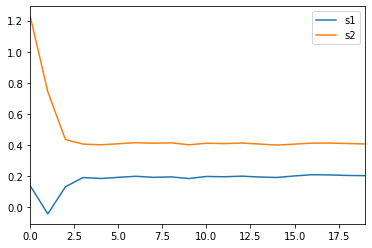

In [468]:
predictionDF[['s1','s2']].plot()

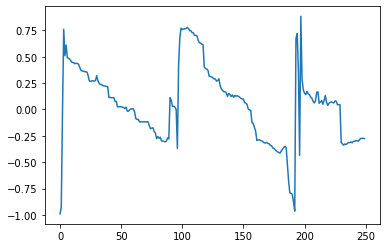

In [469]:
pyplot.plot(test[:, 0, 0]);

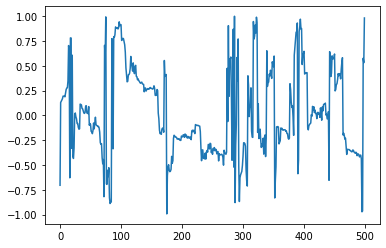

In [442]:
pyplot.plot(train[:, 19, 0]);